In [35]:
# Import necessary packages
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset

import h5py
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report

from torchvision import transforms, models

import random


In [36]:
seed = 7
random.seed(seed)
np.random.seed(seed)
torch.manual_seed(seed)
torch.cuda.manual_seed_all(seed)


In [37]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device


device(type='cpu')

In [38]:
# Pipeline for preprocessing of the image.
transform = transforms.Compose([
    transforms.ToPILImage(),
    transforms.Resize((224, 224)),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                         std=[0.229, 0.224, 0.225])
])


In [44]:
class H5Dataset(Dataset):
    def __init__(self, file_path, image_key, label_key, transform=None):
        self.f = h5py.File(file_path, "r")
        self.images = self.f[image_key][:]
        self.labels = self.f[label_key][:]
        self.transform = transform

    def __len__(self):
        return self.images.shape[0]

    def __getitem__(self, idx):
        img = self.images[idx]
        label = self.labels[idx]

        if self.transform:
            img = self.transform(img)

        label = torch.tensor(label, dtype=torch.float32)
        return img, label


In [45]:
train_data = H5Dataset(
    "train_catvnoncat.h5",
    image_key="train_set_x",
    label_key="train_set_y",
    transform=transform
)

test_data = H5Dataset(
    "test_catvnoncat.h5",
    image_key="test_set_x",
    label_key="test_set_y",
    transform=transform
)


In [48]:
train_loader = DataLoader(train_data, batch_size=32, shuffle=True)
test_loader  = DataLoader(test_data, batch_size=32, shuffle=False)




In [49]:
model = models.resnet18(pretrained=True)

# Replace final layer for binary classification
num_features = model.fc.in_features
model.fc = nn.Linear(num_features, 1)

model = model.to(device)


In [50]:
criterion = nn.BCEWithLogitsLoss()
optimizer = optim.Adam(model.parameters(), lr=1e-5)
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=5, gamma=1e-6)

num_epochs = 10


In [51]:
train_losses = []

for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0

    for imgs, labels in train_loader:
        imgs, labels = imgs.to(device), labels.to(device).unsqueeze(1)

        optimizer.zero_grad()

        outputs = model(imgs)
        loss = criterion(outputs, labels)

        loss.backward()
        optimizer.step()

        running_loss += loss.item() * imgs.size(0)

    scheduler.step()

    epoch_loss = running_loss / len(train_loader.dataset)
    train_losses.append(epoch_loss)
    print(f"Epoch {epoch+1}/{num_epochs} — Loss: {epoch_loss:.4f}")


Epoch 1/10 — Loss: 0.7121
Epoch 2/10 — Loss: 0.5836
Epoch 3/10 — Loss: 0.4667
Epoch 4/10 — Loss: 0.3823
Epoch 5/10 — Loss: 0.3274
Epoch 6/10 — Loss: 0.2842
Epoch 7/10 — Loss: 0.2870
Epoch 8/10 — Loss: 0.2977
Epoch 9/10 — Loss: 0.2818
Epoch 10/10 — Loss: 0.2978


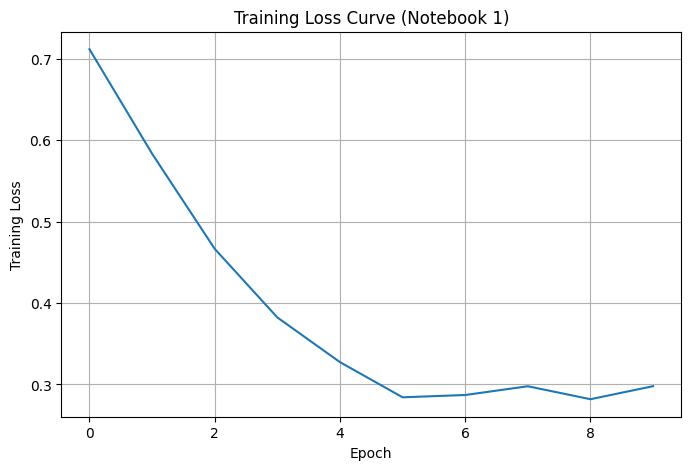

In [52]:
plt.figure(figsize=(8,5))
plt.plot(train_losses)
plt.xlabel("Epoch")
plt.ylabel("Training Loss")
plt.title("Training Loss Curve (Notebook 1)")
plt.grid(True)
plt.show()


In [55]:
model.eval()

all_preds = []
all_labels = []

with torch.no_grad():
    for images, labels in test_loader:
        images = images.to(device)
        labels = labels.to(device).unsqueeze(1)

        outputs = model(images)
        preds = (torch.sigmoid(outputs) > 0.5).float()

        all_preds.append(preds.cpu().numpy())
        all_labels.append(labels.cpu().numpy())

all_preds = np.vstack(all_preds).flatten()
all_labels = np.vstack(all_labels).flatten()

test_accuracy = np.mean(all_preds == all_labels)

print("Test Accuracy:", test_accuracy)


Test Accuracy: 1.0


In [56]:
incorrect_indices = np.where(all_preds != all_labels)[0]
print("Incorrect test indices:", incorrect_indices)
print("Number incorrect:", len(incorrect_indices))


Incorrect test indices: []
Number incorrect: 0


In [57]:
indices_to_show = incorrect_indices[:4]

plt.figure(figsize=(10, 10))

for i, idx in enumerate(indices_to_show):
    img, label = test_data[idx]
    img_show = np.transpose(img.numpy(), (1, 2, 0))

    # undo normalization for display
    img_show = img_show * np.array([0.229, 0.224, 0.225]) + np.array([0.485, 0.456, 0.406])
    img_show = np.clip(img_show, 0, 1)

    pred_label = int(all_preds[idx])

    plt.subplot(2, 2, i+1)
    plt.imshow(img_show)
    plt.title(f"True={int(label)}  Pred={pred_label}")
    plt.axis("off")

plt.tight_layout()
plt.show()


<Figure size 1000x1000 with 0 Axes>